In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        !unzip -o '/kaggle/input/instacart-market-basket-analysis/{filename}'
        print(os.path.join(dirname, filename))

Archive:  /kaggle/input/instacart-market-basket-analysis/departments.csv.zip
  inflating: departments.csv         
   creating: __MACOSX/
  inflating: __MACOSX/._departments.csv  
/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
Archive:  /kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
  inflating: sample_submission.csv   
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
Archive:  /kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
  inflating: order_products__train.csv  
  inflating: __MACOSX/._order_products__train.csv  
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
Archive:  /kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
  inflating: order_products__prior.csv  
  inflating: __MACOSX/._order_products__prior.csv  
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
Archive:  /kaggle/input/instacart-market-bask

In [3]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
sn.set_palette(palette="OrRd")

In [4]:
#!unzip -o /kaggle/input/instacart-market-basket-analysis/aisles.csv.zip
aisles = pd.read_csv('/kaggle/working/aisles.csv')
departments = pd.read_csv('/kaggle/working/departments.csv')
products = pd.read_csv('/kaggle/working/products.csv')
orders = pd.read_csv('/kaggle/working/orders.csv')
orderProductsTrain = pd.read_csv('/kaggle/working/order_products__train.csv')
orderProductsPrior = pd.read_csv('/kaggle/working/order_products__prior.csv')

데이터 셋을 탐색하고 이해도를 높일 방법을 시도

* orders(340만 행, 206k 사용자):

order_id: 주문 식별자  
user_id: 고객 식별자  
eval_set: 이 주문이 속한 평가 세트( SET아래 설명 참조)  
order_number: 이 사용자의 주문 순서 번호(1 = 첫 번째, n = n 번째)  
order_dow: 주문한 요일  
order_hour_of_day: 주문이 접수된 시간  
days_since_prior: 마지막 주문 이후 일수, 최대 30일(NA order_number= 1)  
    
* products(50k 행):

product_id: 제품 식별자  
product_name: 제품명  
aisle_id: 외래 키  
department_id: 외래 키  

* aisles(134행):  

aisle_id: 세부 상품 분류 식별자  
aisle: 세부 상품 분류명 (ex. 에너지 그래놀라바, 인스턴트, 건면 등)

* deptartments(21행):

department_id: 상품 분류 식별자  
department: 상품 분류명 (ex. 냉동, 아기, 빵,과자, 동물, 주류 등)  

* order_products__SET(30m+ 행):

order_id: 외래 키  
product_id: 외래 키  
add_to_cart_order: 각 상품이 장바구니에 담긴 순서  
reordered: 이 제품이 과거에 이 사용자가 주문한 적이 있으면 1, 그렇지 않으면 0  
여기서 SET는 다음 네 가지 평가 세트 중 하나입니다( eval_set in orders).  

"prior": 해당 사용자의 가장 최근 주문 이전 주문(\~3.2m 주문)  
"train": 참가자에게 교육 데이터 제공(\~131k 주문)  
"test": 기계 학습 대회를 위해 예약된 테스트 데이터(~75k 주문)  

### 사람들은 보통 언제 주문을 하는가?!

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Order Count Across Hour Of The Day')]

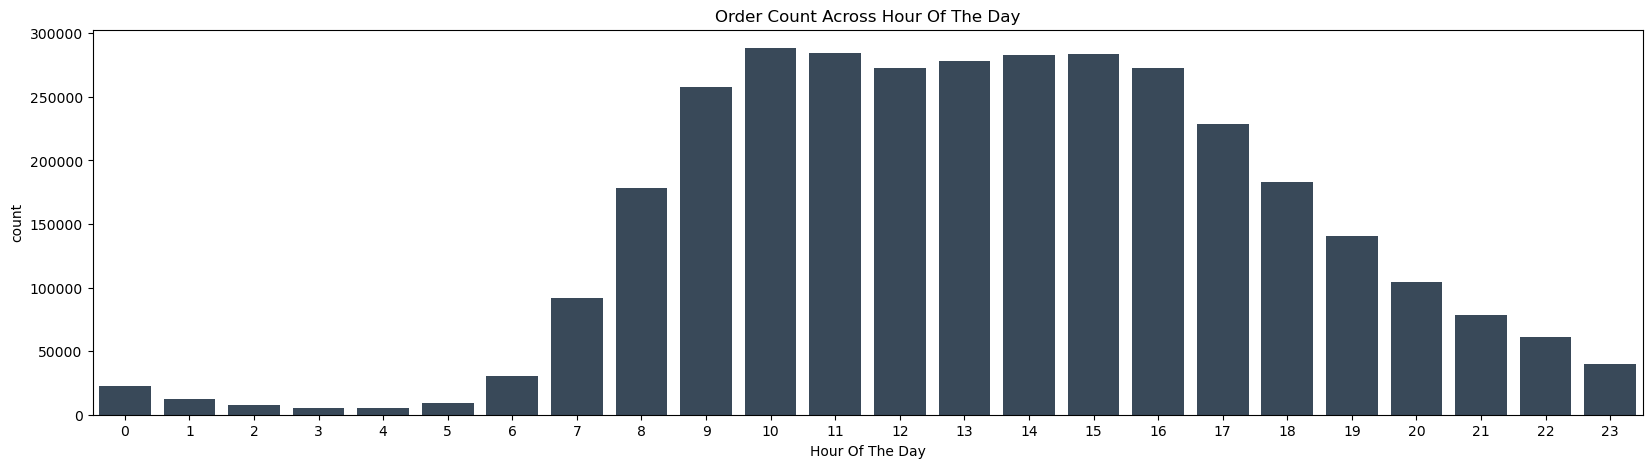

In [5]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.countplot(data=orders, x="order_hour_of_day", ax=ax, color="#34495e")
ax.set(xlabel="Hour Of The Day", title="Order Count Across Hour Of The Day")

일반 업무시간대? 활동시간대와 비슷한 경향

### 일주일 중 언제 주문을 할까요?!

[Text(0.5, 0, 'Day Of The Week'),
 Text(0.5, 1.0, 'Order Count Across Days Of The Week')]

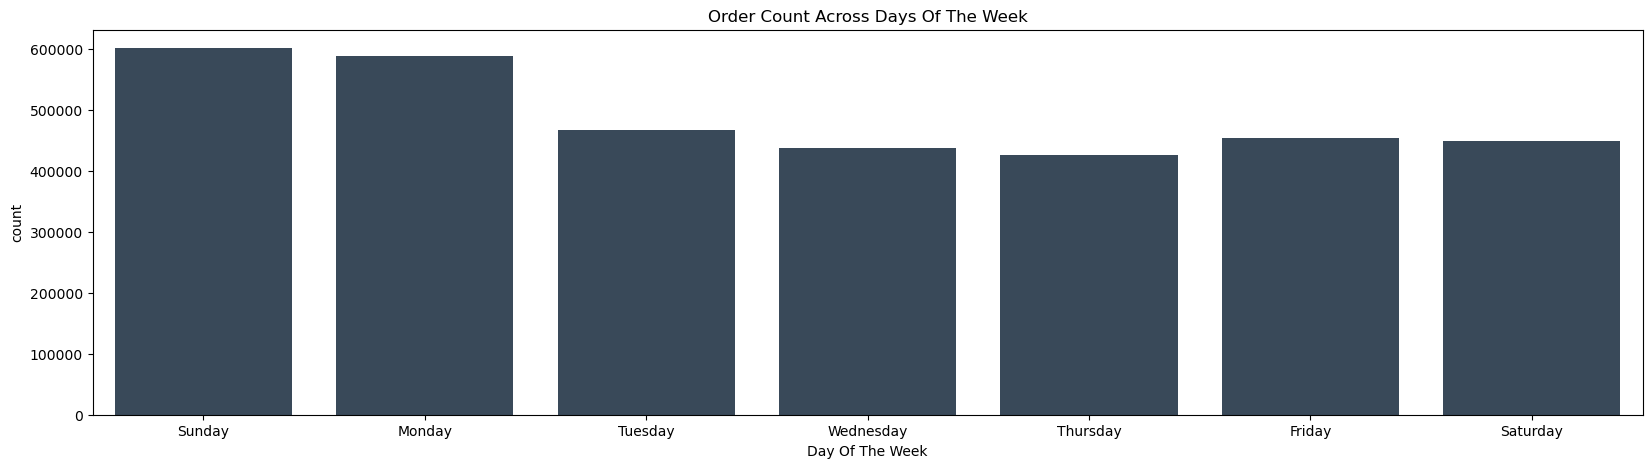

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ordersDay = orders[["order_dow"]].replace({0:"Sunday", 1:"Monday", 2:"Tuesday", 3:"Wednesday", 4: "Thursday", 5:"Friday", 6:"Saturday"})

sn.countplot(color="#34495e", data=ordersDay, x="order_dow", ax=ax, order=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
ax.set(xlabel='Day Of The Week', title="Order Count Across Days Of The Week")

0을 일요일로 잡았지만 토요일이 월요일보다 상품구매량이 많다고 생각하여, 0은 토요일, 1은 일요일로 수정해야함.

### 사람들은 보통 언제 재주문하나요?!

[Text(0.5, 0, 'Hour Of The Day'), Text(0.5, 1.0, 'Reorder Count')]

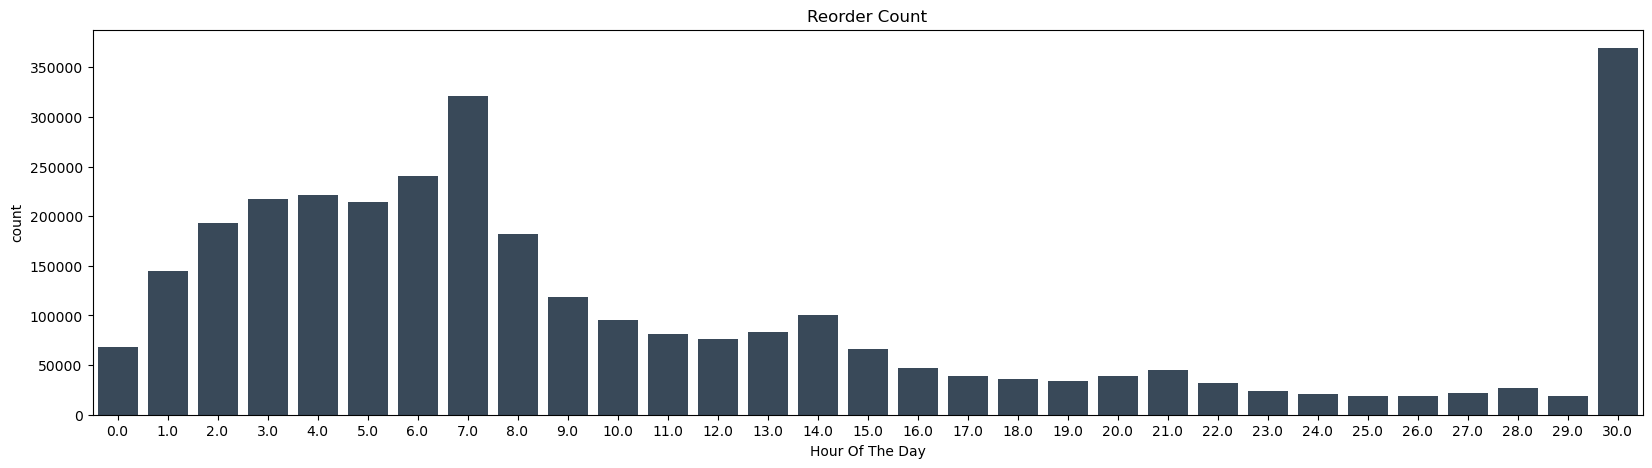

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.countplot(color="#34495e", data=orders, x="days_since_prior_order", ax=ax)
ax.set(xlabel="Hour Of The Day", title="Reorder Count")

재구매시기가 1주일 이내가 가장 많지만, 7일 간격으로 조금씩 상승하는것과, 30일차에 많이 증가하는 것을 확인.
30일차에 instacart에서 따로 무언가를 하는지 확인해봤지만, 별도 이벤트는 없는것으로 추정, 30일이 경과가 안되서 해당되지 않아서 그럴 수 있다고 판단.

### 일반적으로 사용자가 주문한 수량은 몇개 인가요?!

[Text(0.5, 0, 'Order Count'), Text(0.5, 1.0, 'Order Count')]

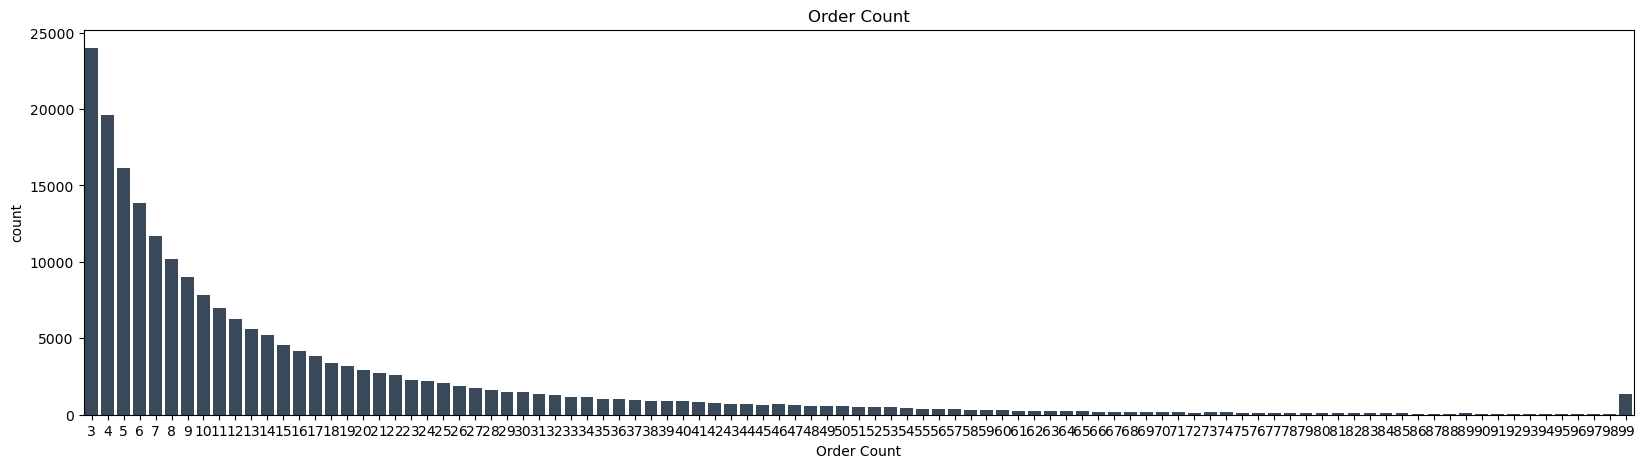

In [8]:
orderCount = orders[orders["eval_set"]=="prior"].groupby(by=["user_id"])["order_id"].count().to_frame()
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sn.countplot(color="#34495e", data=orderCount, x="order_id", ax=ax)
ax.set(xlabel="Order Count", title="Order Count")

3~5가지 정도가 가장 많고, 드물게 대량 구매자가 존재

### 주문당 몇가지의 품목을 구매하는지!

[Text(0.5, 0, 'Order Count'),
 Text(0.5, 1.0, 'Count Of Items People Buy In Prior')]

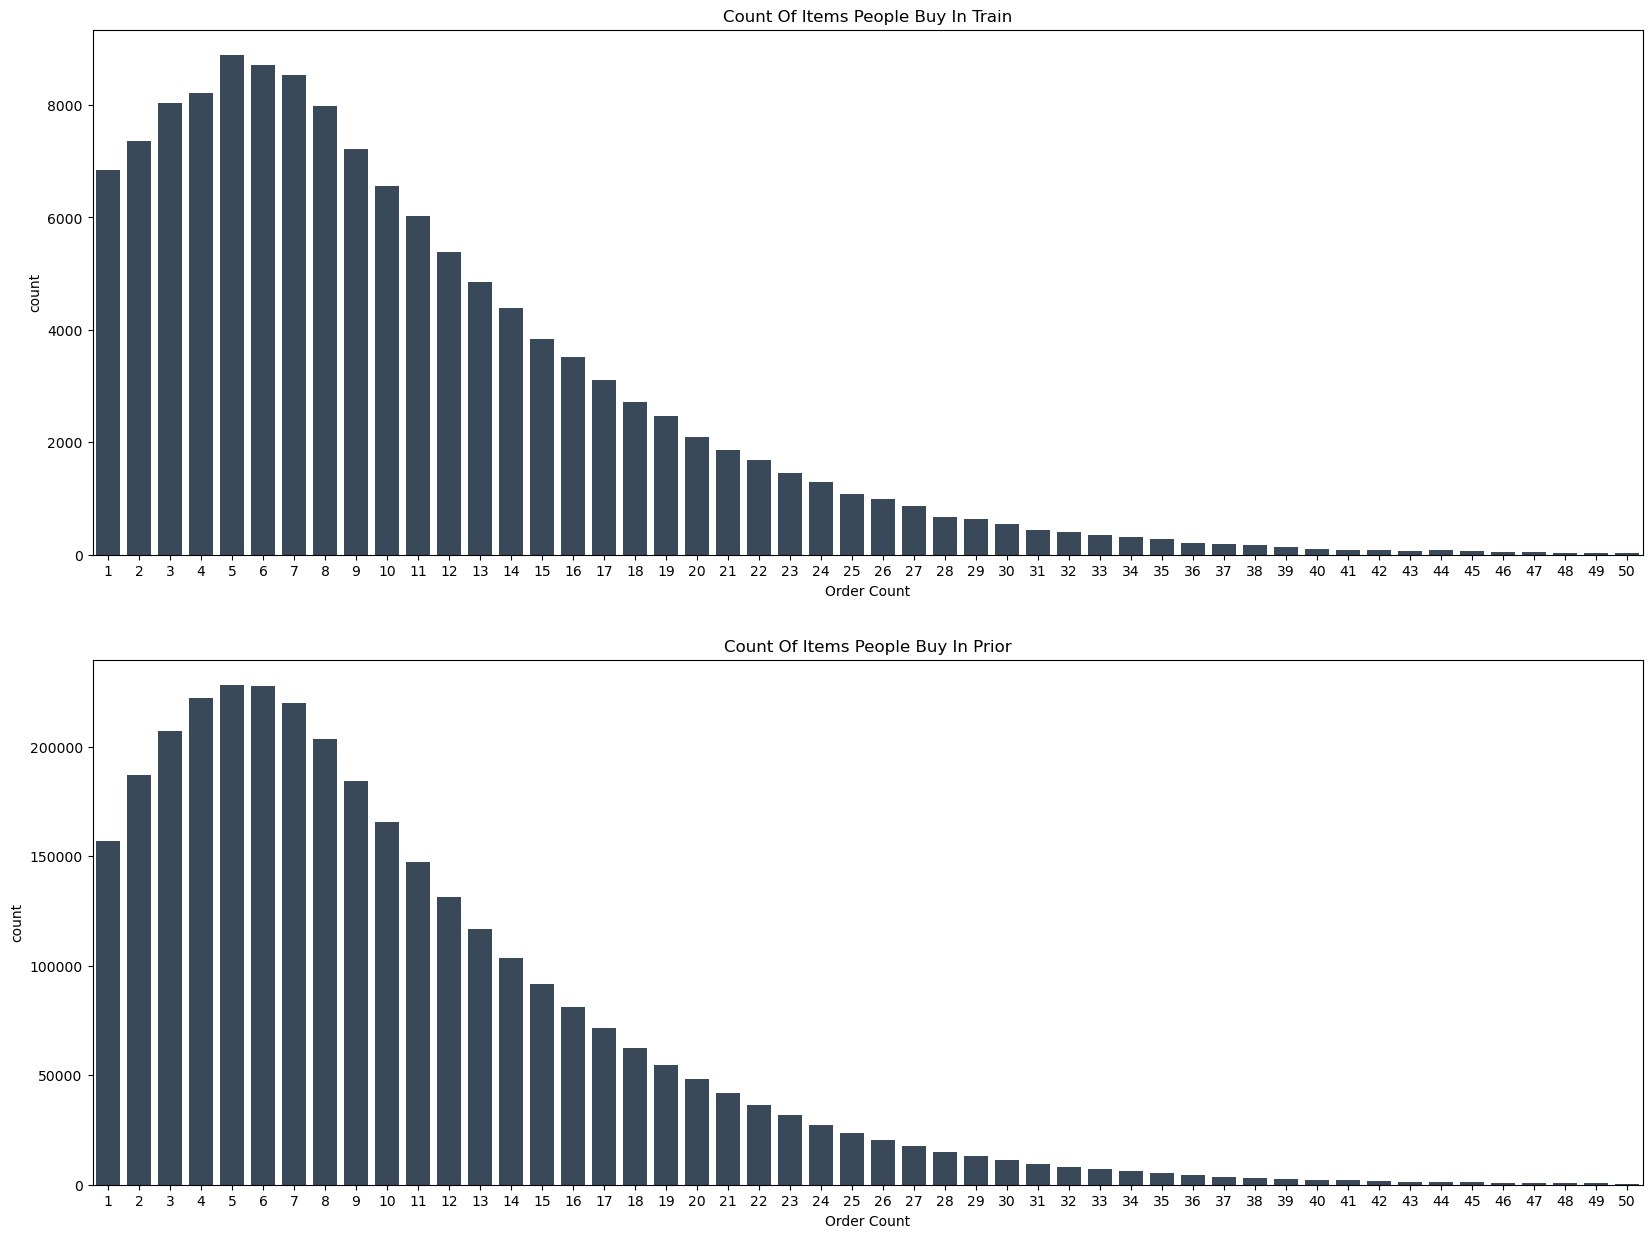

In [9]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(20, 15)
orderCountsPrior = orderProductsPrior.groupby("order_id")["product_id"].count().to_frame()["product_id"].value_counts().to_frame()
orderCountsPrior["count"] = orderCountsPrior["product_id"]
orderCountsPrior["no_of_products"] = orderCountsPrior.index
orderCountsTrain = orderProductsTrain.groupby("order_id")["product_id"].count().to_frame()["product_id"].value_counts().to_frame()
orderCountsTrain["count"] = orderCountsTrain["product_id"]
orderCountsTrain["no_of_products"] = orderCountsTrain.index
sn.barplot(data=orderCountsTrain.head(50), x="no_of_products", y="count", ax=ax1, color="#34495e")
sn.barplot(data=orderCountsPrior.head(50), x="no_of_products", y="count", ax=ax2, color="#34495e")
ax1.set(xlabel="Order Count", title="Count Of Items People Buy In Train")
ax2.set(xlabel="Order Count", title="Count Of Items People Buy In Prior")

### 가장 많이 팔린 제품

,product_id,count,product_name,aisle_id,department_id
0,24852,18726,Banana,24,4
1,13176,15480,Bag of Organic Bananas,24,4
2,21137,10894,Organic Strawberries,24,4
3,21903,9784,Organic Baby Spinach,123,4
4,47626,8135,Large Lemon,24,4
5,47766,7409,Organic Avocado,24,4
6,47209,7293,Organic Hass Avocado,24,4
7,16797,6494,Strawberries,24,4
8,26209,6033,Limes,24,4
9,27966,5546,Organic Raspberries,123,4


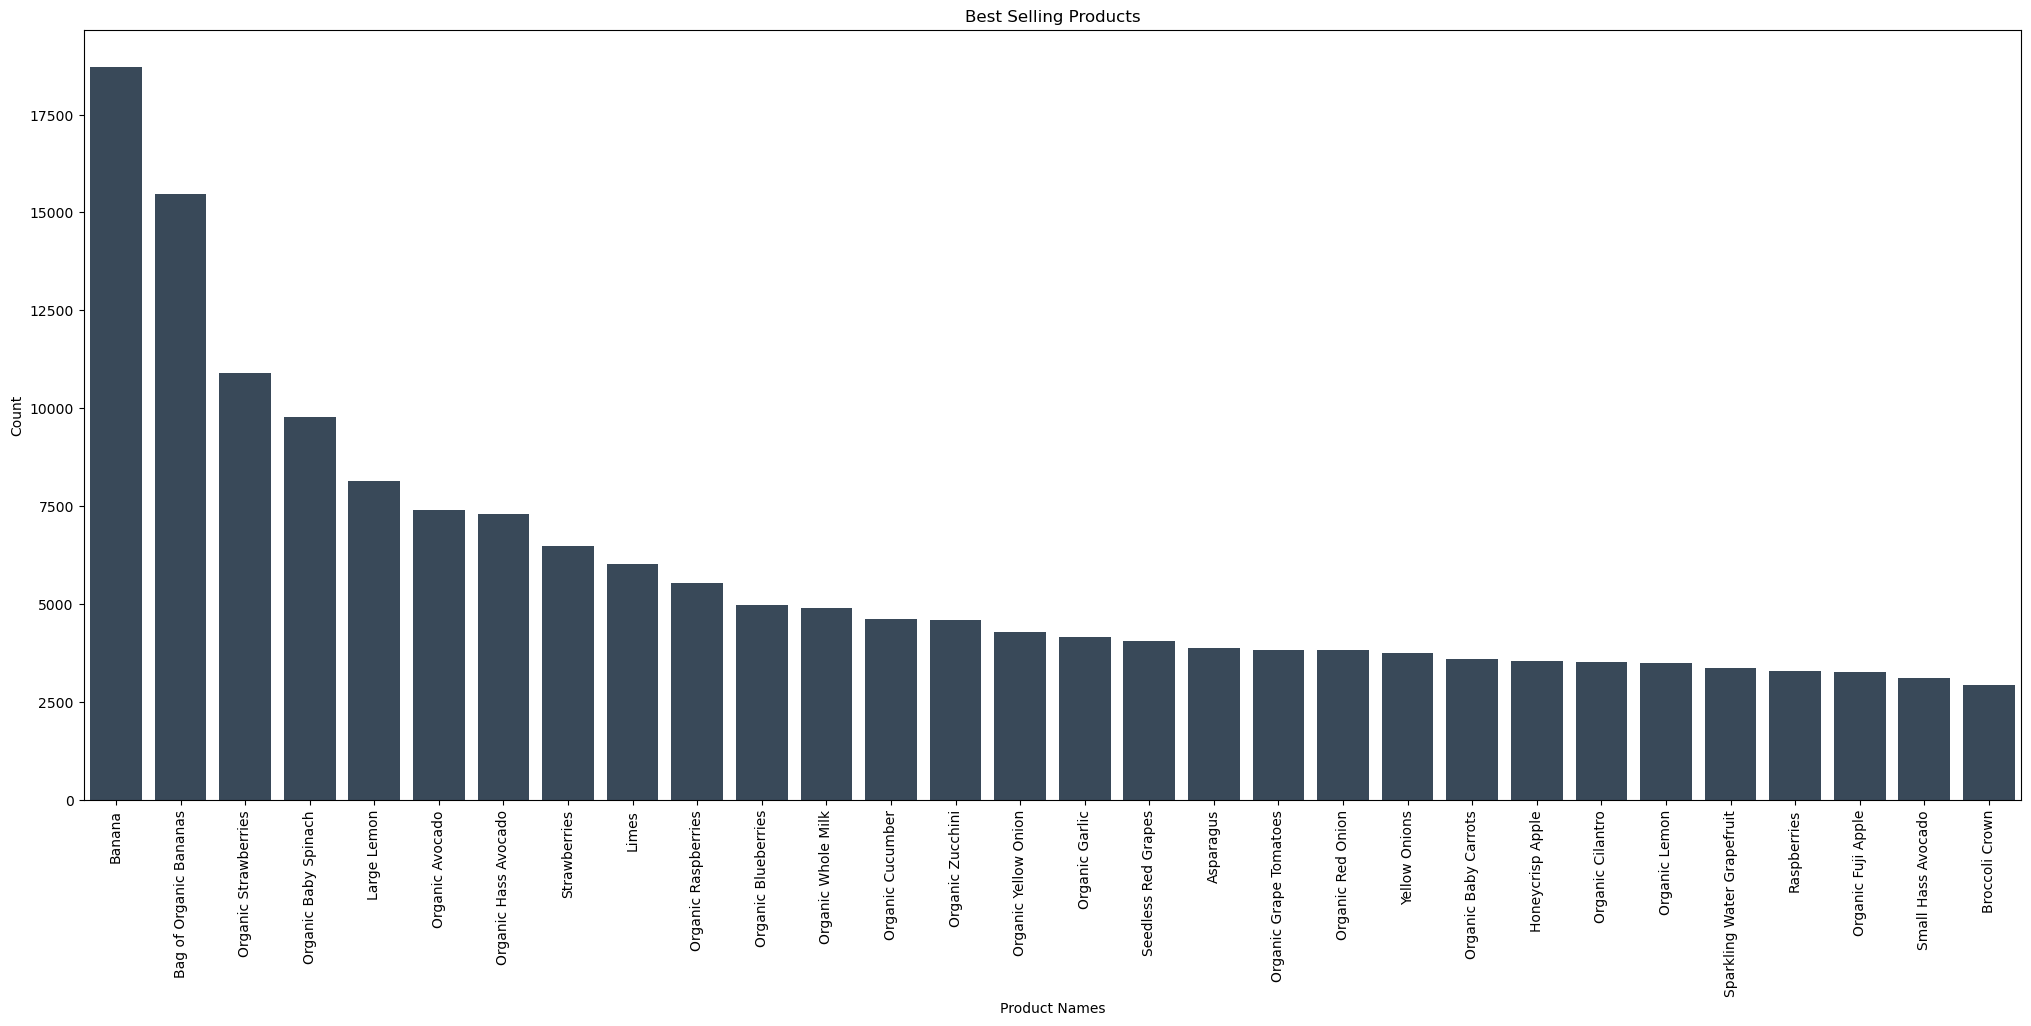

In [10]:
productsCount = orderProductsTrain["product_id"].value_counts().to_frame()
productsCount["count"] = productsCount.product_id
productsCount['product_id'] = productsCount.index
mergedData = pd.merge(productsCount, products, how="left", on="product_id").sort_values(by="count", ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sn.barplot(data=mergedData.head(30), x="product_name", y="count", ax=ax, orient="v", color="#34495e")
ax.set(xlabel="Product Names", ylabel="Count", title="Best Selling Products")
plt.xticks(rotation=90)

mergedData.head(10)

### 재구매율이 높은 상품

,product_id,count,reordered_count,reordered_ratio,product_name,aisle_id,department_id
0,38900,1,1.0,1.0,Plain Golden Toasted Bread Crumbs,5,13
1,33154,1,1.0,1.0,Giant Chocolate Fudge Ice Cream Bars,37,1
2,26614,2,2.0,1.0,Organic Chinese Mung Bean Sprouts,123,4
3,9500,2,2.0,1.0,Sugar-Free Wintergreen Chewing Gum,46,19
4,13867,2,2.0,1.0,Crumbled Gorgonzola,21,16
5,34738,2,2.0,1.0,Espresso Chocolate,45,19
6,47538,2,2.0,1.0,Compleats Homestyle Chicken & Dumplings,4,9
7,11949,2,2.0,1.0,Sea Salt Bean & Rice Chips,107,19
8,47221,2,2.0,1.0,Premium Roast Decaf K Cup,26,7
9,13973,2,2.0,1.0,Seasoned Steak Fries,129,1


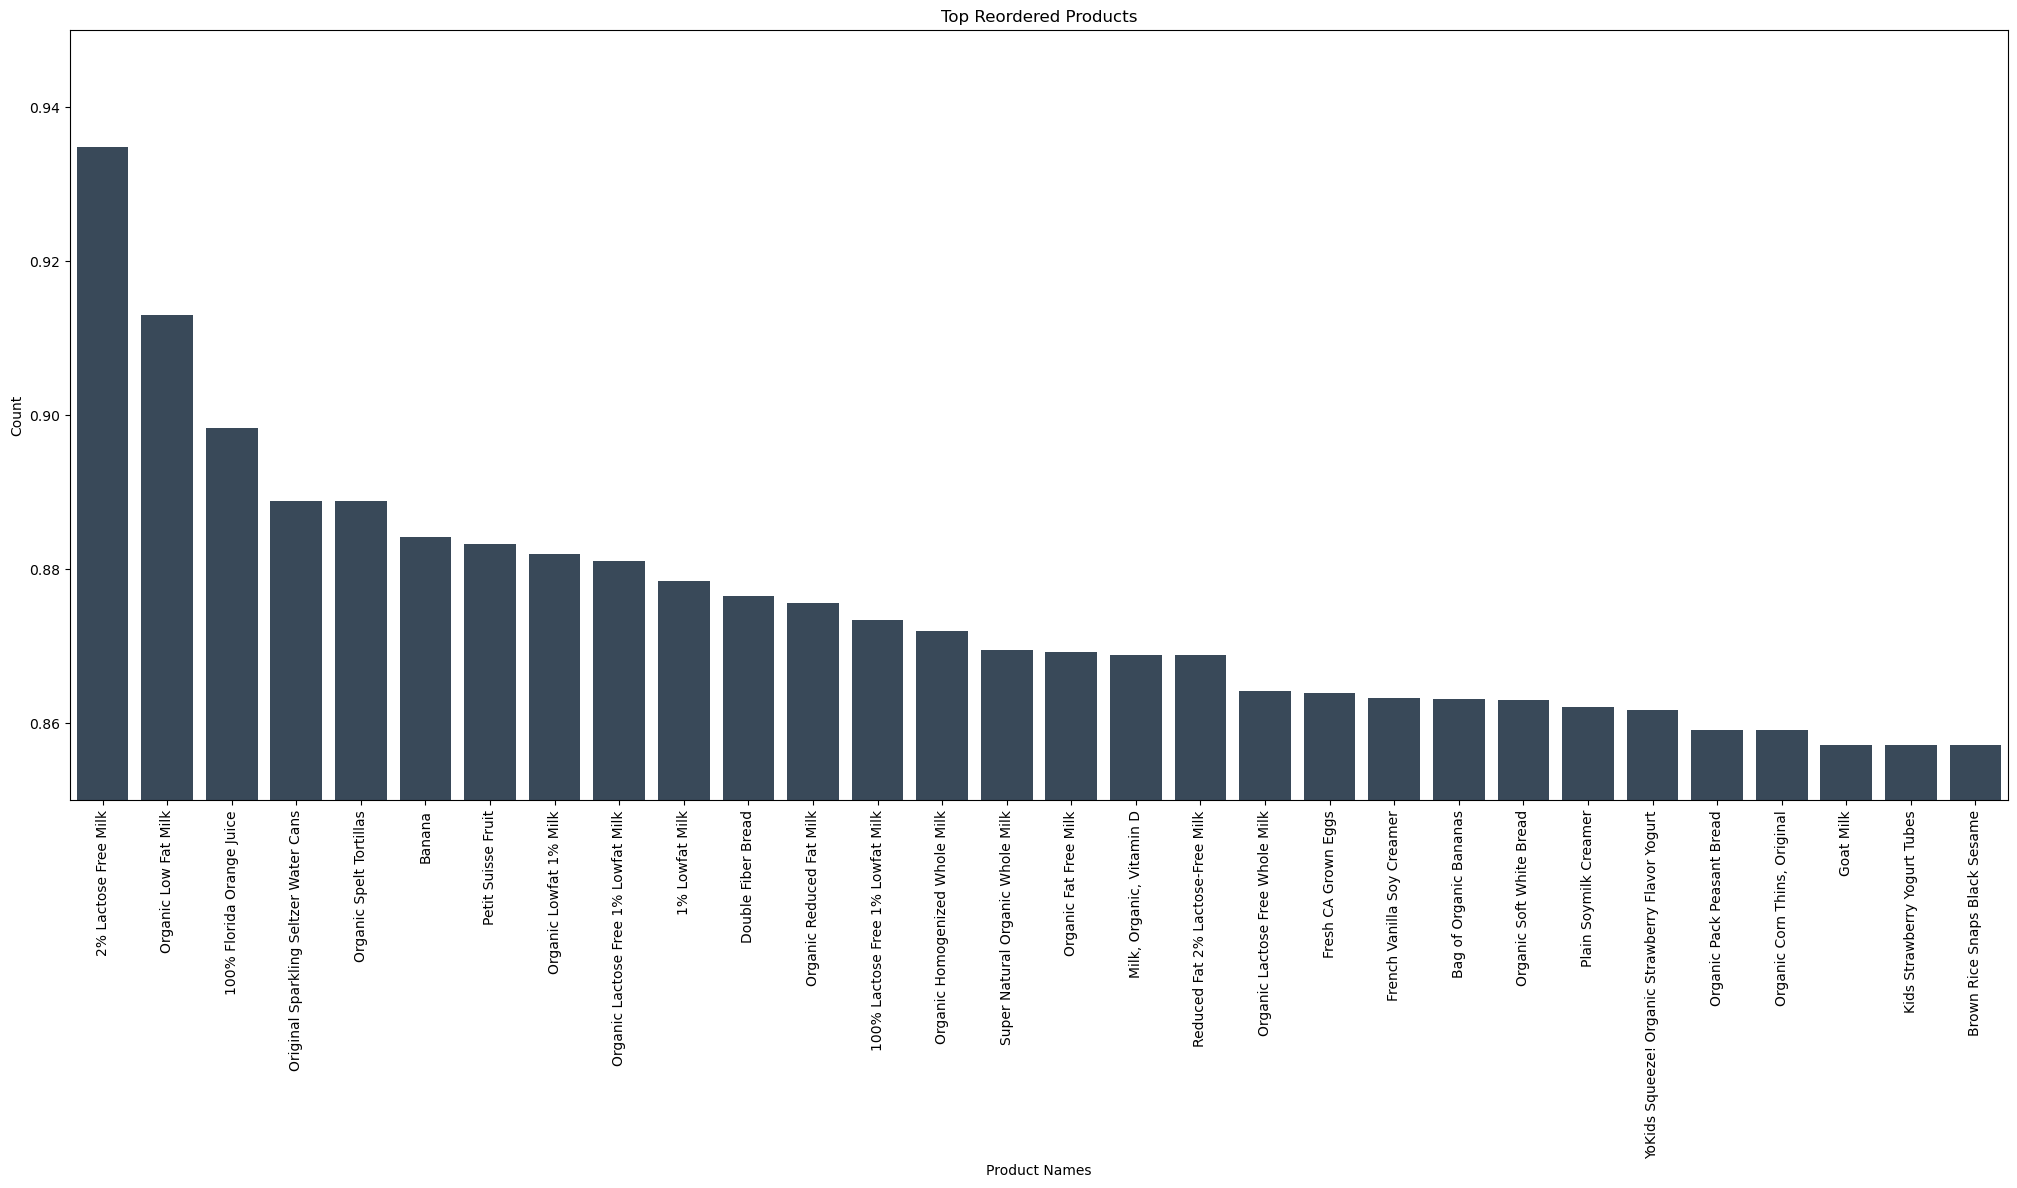

In [11]:
productsCountReordered = orderProductsTrain[orderProductsTrain["reordered"]==1]["product_id"].value_counts().to_frame()
productsCountReordered["reordered_count"] = productsCountReordered.product_id
productsCountReordered["product_id"] = productsCountReordered.index
productCountReorderedMerged = pd.merge(productsCount, productsCountReordered, how="left", on="product_id").sort_values(by="count", ascending=False)
productCountReorderedMerged["reordered_ratio"] = productCountReorderedMerged["reordered_count"]/productCountReorderedMerged["count"]
productCountReorderedMerged.sort_values(by="reordered_ratio", ascending=False, inplace=True)
productMerged = pd.merge(productCountReorderedMerged, products, how="left", on="product_id")

fig,ax = plt.subplots()
fig.set_size_inches(25, 10)
sn.barplot(data=productMerged[productMerged["count"] > 40].head(30), x="product_name", y="reordered_ratio", color="#34495e", ax=ax, orient="v")
ax.set(xlabel="Product Names", ylabel="Count", title="Top Reordered Products")
ax.set_ylim(0.85, 0.95)
plt.xticks(rotation=90)

productMerged.head(10)

### 사람들이 장바구니에 먼저 넣는 물건

,product_id,count,reordered_count,first_ordered_ratio,product_name,aisle_id,department_id
0,34728,1,1.0,1.0,Habanero Fire Roasted Salsa,51,13
1,48242,1,1.0,1.0,Honey Lavender Scent Purclean HE Liquid Laundr...,75,17
2,29461,1,1.0,1.0,Organic & Cold-Pressed Vegetable & Fruit Juice...,31,7
3,12177,1,1.0,1.0,Spring & Renewal Heavy Traffic Carpet Foam,114,17
4,43318,1,1.0,1.0,2pk Artisan Thin Pizza Crust,128,3
5,12411,1,1.0,1.0,"Frankfurters, Beef, Colossal",106,12
6,30267,1,1.0,1.0,Seckel Pear,24,4
7,45020,1,1.0,1.0,Arnica Oil,133,11
8,20053,1,1.0,1.0,Clasico Crispy Yellow Corn Tortilla Chips,107,19
9,31723,1,1.0,1.0,Umcka Cold + Flu Multi-Action Natural Relief S...,11,11


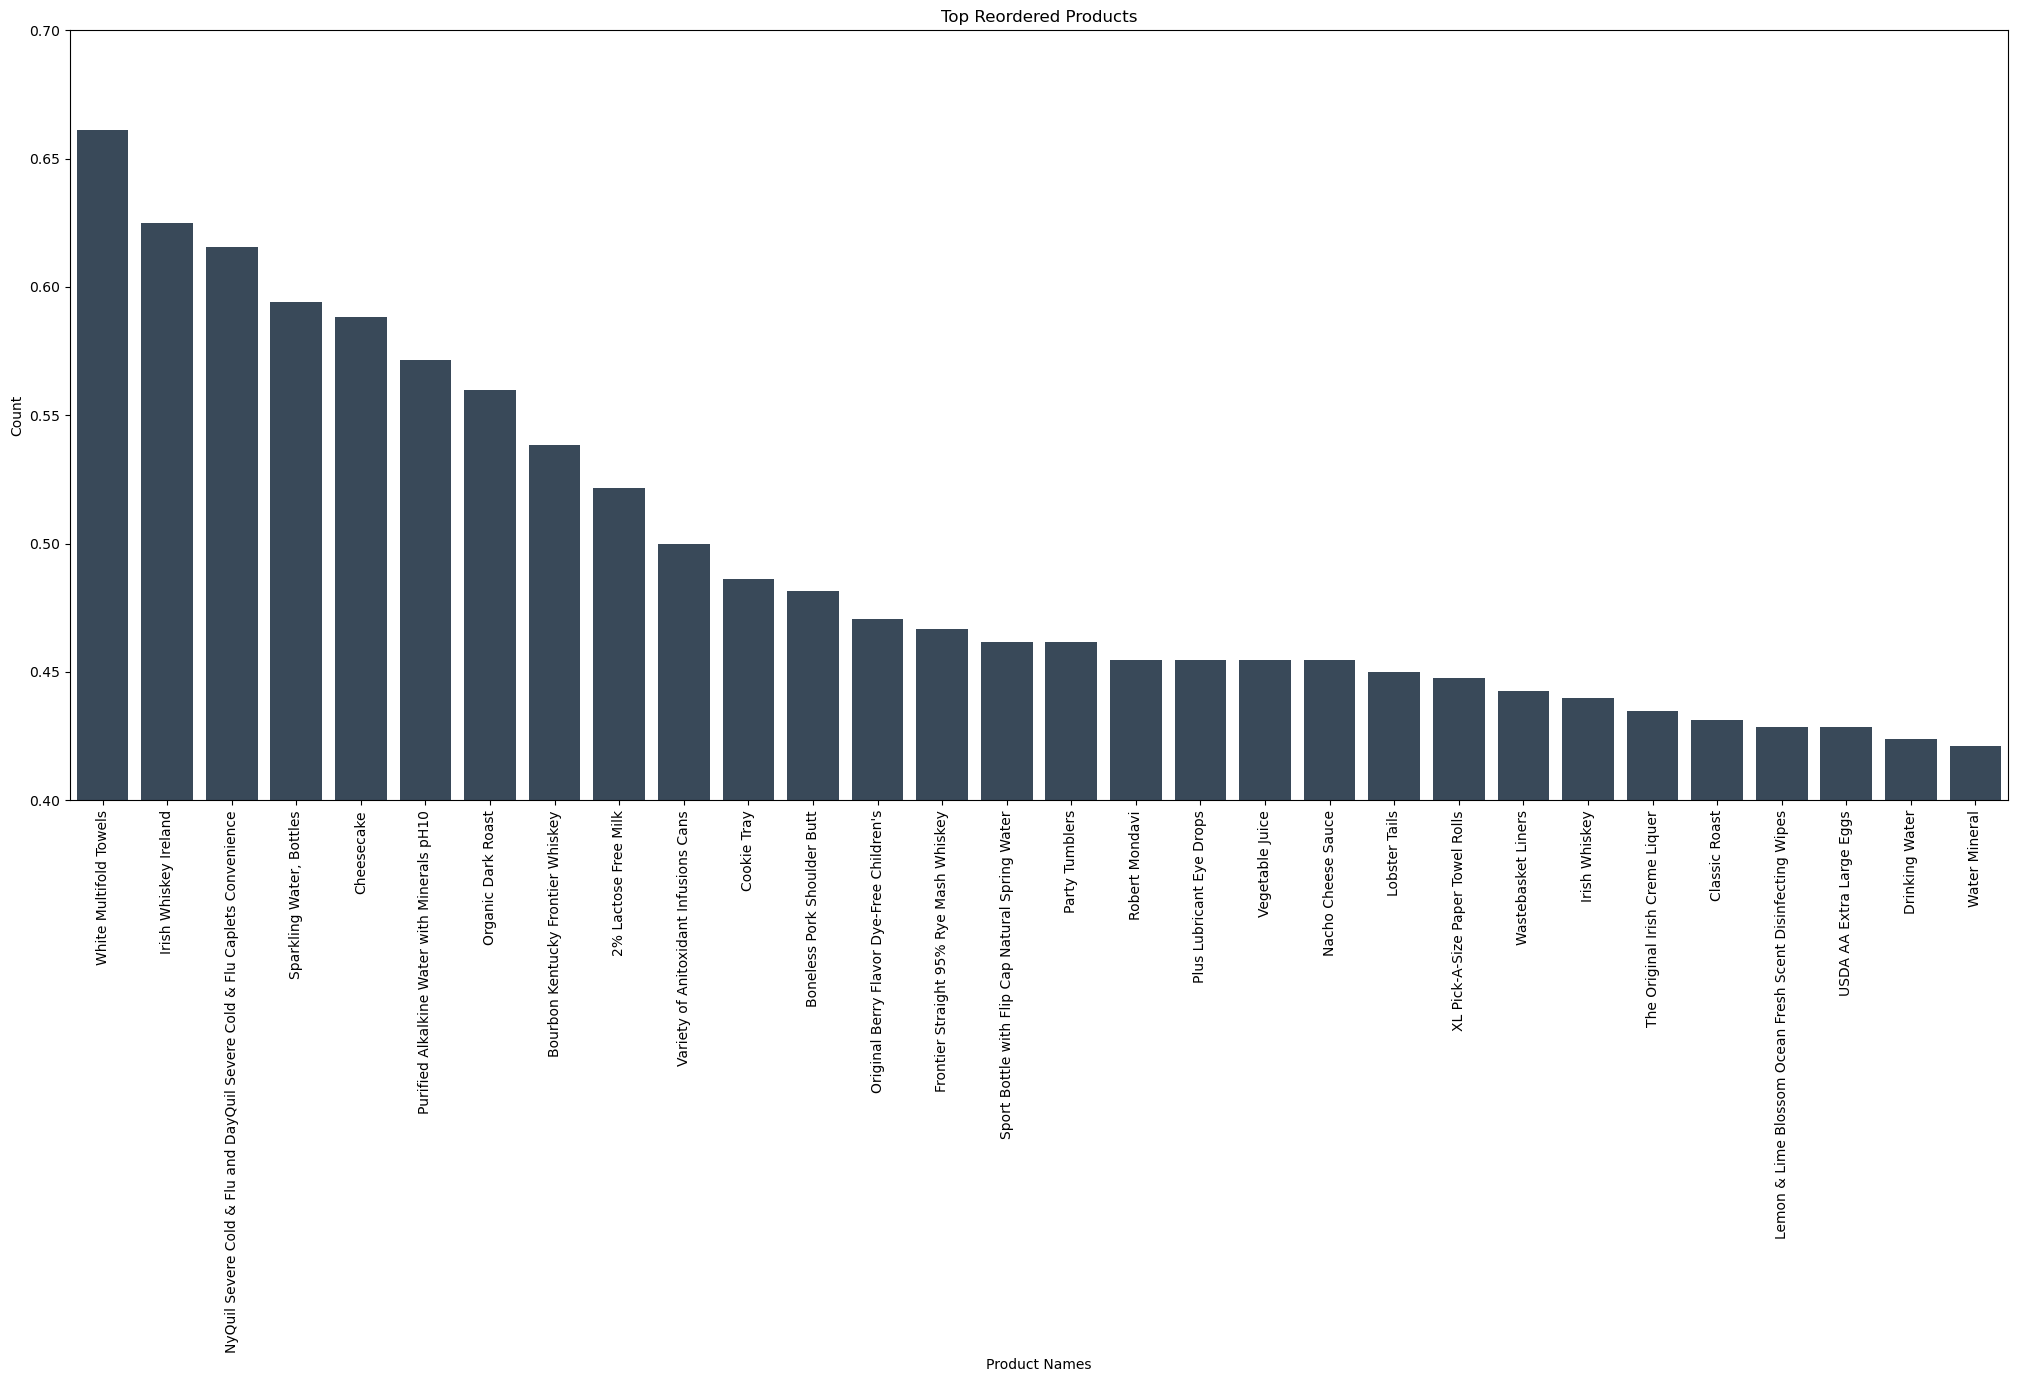

In [12]:
productsCountFirst = orderProductsTrain[orderProductsTrain["add_to_cart_order"]==1]["product_id"].value_counts().to_frame()
productsCountFirst["reordered_count"] = productsCountFirst.product_id
productsCountFirst["product_id"] = productsCountFirst.index
productCountFirstMerged = pd.merge(productsCount,productsCountFirst,how="left",on="product_id").sort_values(by="count",ascending=False)
productCountFirstMerged["first_ordered_ratio"] = productCountFirstMerged["reordered_count"]/productCountFirstMerged["count"]
productCountFirstMerged.sort_values(by="first_ordered_ratio",ascending=False,inplace=True)
firstMerged = pd.merge(productCountFirstMerged,products,how="left",on="product_id")

fig,ax = plt.subplots()
fig.set_size_inches(25,10)
sn.barplot(data=firstMerged[firstMerged["count"]>10].head(30),x="product_name",y="first_ordered_ratio",color="#34495e",ax=ax,orient="v")
ax.set(xlabel='Product Names',ylabel="Count",title="Top Reordered Products")
ax.set_ylim(0.4,.7)
plt.xticks(rotation=90)

firstMerged.head(10)

In [16]:
pro_list_1 = list(orderProductsPrior[orderProductsPrior['order_id'] == 2]['product_id'].values)

In [18]:
for i in pro_list_1:
    print(products[products['product_id'] == i].product_name)

33119    Organic Egg Whites
Name: product_name, dtype: object
28984    Michigan Organic Kale
Name: product_name, dtype: object
9326    Garlic Powder
Name: product_name, dtype: object
45917    Coconut Butter
Name: product_name, dtype: object
30034    Natural Sweetener
Name: product_name, dtype: object
17793    Carrots
Name: product_name, dtype: object
40140    Original Unflavored Gelatine Mix
Name: product_name, dtype: object
1818    All Natural No Stir Creamy Almond Butter
Name: product_name, dtype: object
43667    Classic Blend Cole Slaw
Name: product_name, dtype: object


In [37]:
aislesCount = aisles.copy()
list_aisle_count = list((mergedData[mergedData['aisle_id'] == i]['count'].sum()) for i in aisles['aisle_id'])
aislesCount.insert(2, 'count', list_aisle_count)
aislesCount

,aisle_id,aisle,count
0,1,prepared soups salads,2936
1,2,specialty cheeses,3873
2,3,energy granola bars,17449
3,4,instant foods,9917
4,5,marinades meat preparation,2905
...,...,...,...
129,130,hot cereal pancake mixes,6352
130,131,dry pasta,11298
131,132,beauty,287
132,133,muscles joints pain relief,897


### 가장 많이 팔린 aisles

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'fresh vegetables'),
  Text(1, 0, 'fresh fruits'),
  Text(2, 0, 'packaged vegetables fruits'),
  Text(3, 0, 'yogurt'),
  Text(4, 0, 'packaged cheese'),
  Text(5, 0, 'water seltzer sparkling water'),
  Text(6, 0, 'milk'),
  Text(7, 0, 'chips pretzels'),
  Text(8, 0, 'soy lactosefree'),
  Text(9, 0, 'bread'),
  Text(10, 0, 'refrigerated'),
  Text(11, 0, 'ice cream ice'),
  Text(12, 0, 'frozen produce'),
  Text(13, 0, 'eggs'),
  Text(14, 0, 'crackers'),
  Text(15, 0, 'frozen meals'),
  Text(16, 0, 'energy granola bars'),
  Text(17, 0, 'lunch meat'),
  Text(18, 0, 'soft drinks'),
  Text(19, 0, 'cereal'),
  Text(20, 0, 'fresh herbs'),
  Text(21, 0, 'fresh dips tapenades'),
  Text(22, 0, 'soup broth bouillon'),
  Text(23, 0, 'juice nectars'),
  Text(24, 0, 'packaged produce'),
  Text(25, 0, 'baby food formula'),
  Text(26, 0, 'baking ingredien

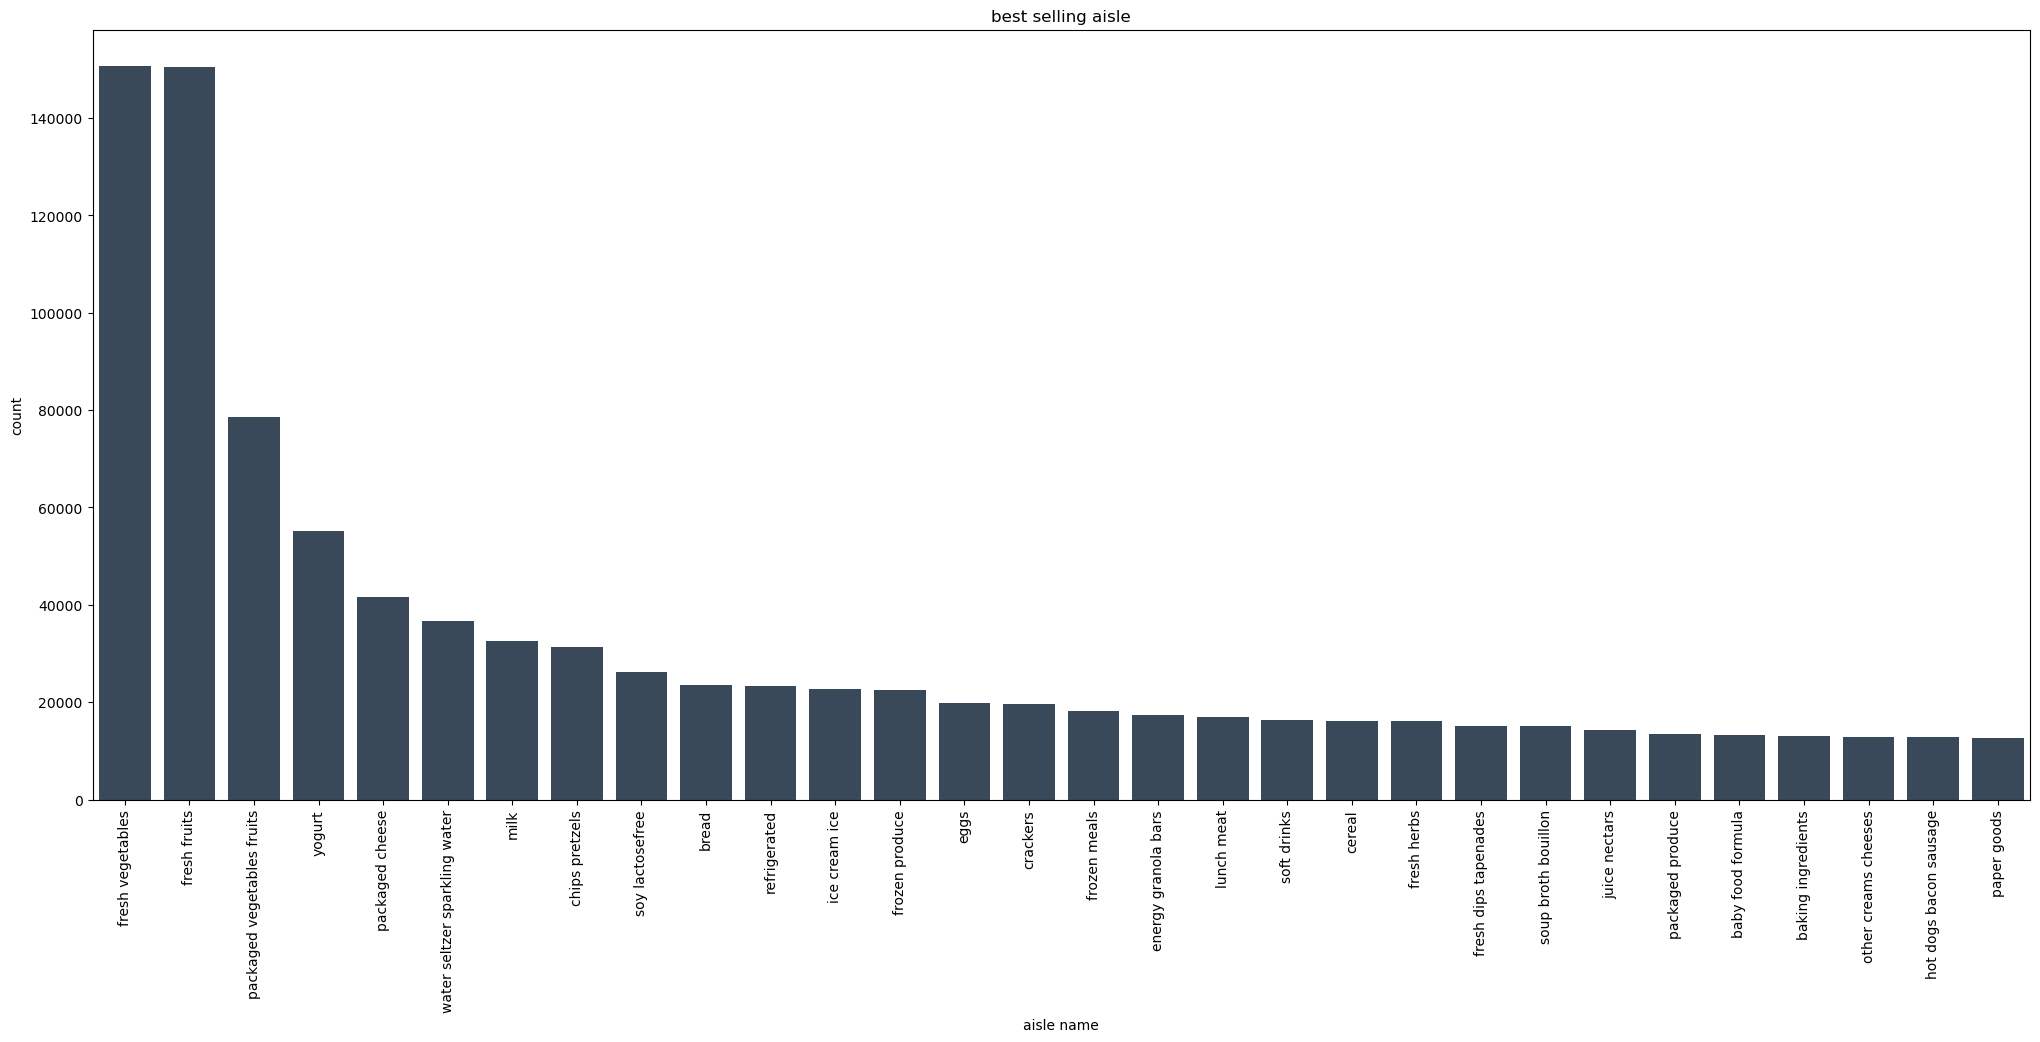

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sn.barplot(data=aislesCount.sort_values(by='count', ascending=False).head(30), x='aisle', y='count', ax=ax, orient='v', color="#34495e")
ax.set(xlabel="aisle name", ylabel='count', title='best selling aisle')
plt.xticks(rotation=90)

In [28]:
departmentsCount = departments.copy()
departmentsCount['count'] = mergedData['department_id'].value_counts().sort_index()
departmentsCount.drop(columns=['count'], inplace=True)
departmentsCount

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [29]:
#departmentsCount = aisles.copy()
list_depart_count = list((mergedData[mergedData['department_id'] == i]['count'].sum()) for i in departments['department_id'])
departmentsCount.insert(2, 'count', list_depart_count)
departmentsCount

,department_id,department,count
0,1,frozen,100426
1,2,other,1795
2,3,bakery,48394
3,4,produce,409087
4,5,alcohol,5598
5,6,international,11902
6,7,beverages,114046
7,8,pets,4497
8,9,dry goods pasta,38713
9,10,bulk,1359


### 가장 많이 팔린 department

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'produce'),
  Text(1, 0, 'dairy eggs'),
  Text(2, 0, 'snacks'),
  Text(3, 0, 'beverages'),
  Text(4, 0, 'frozen'),
  Text(5, 0, 'pantry'),
  Text(6, 0, 'bakery'),
  Text(7, 0, 'canned goods'),
  Text(8, 0, 'deli'),
  Text(9, 0, 'dry goods pasta'),
  Text(10, 0, 'household'),
  Text(11, 0, 'meat seafood'),
  Text(12, 0, 'breakfast'),
  Text(13, 0, 'personal care'),
  Text(14, 0, 'babies'),
  Text(15, 0, 'international'),
  Text(16, 0, 'missing'),
  Text(17, 0, 'alcohol'),
  Text(18, 0, 'pets'),
  Text(19, 0, 'other'),
  Text(20, 0, 'bulk')])

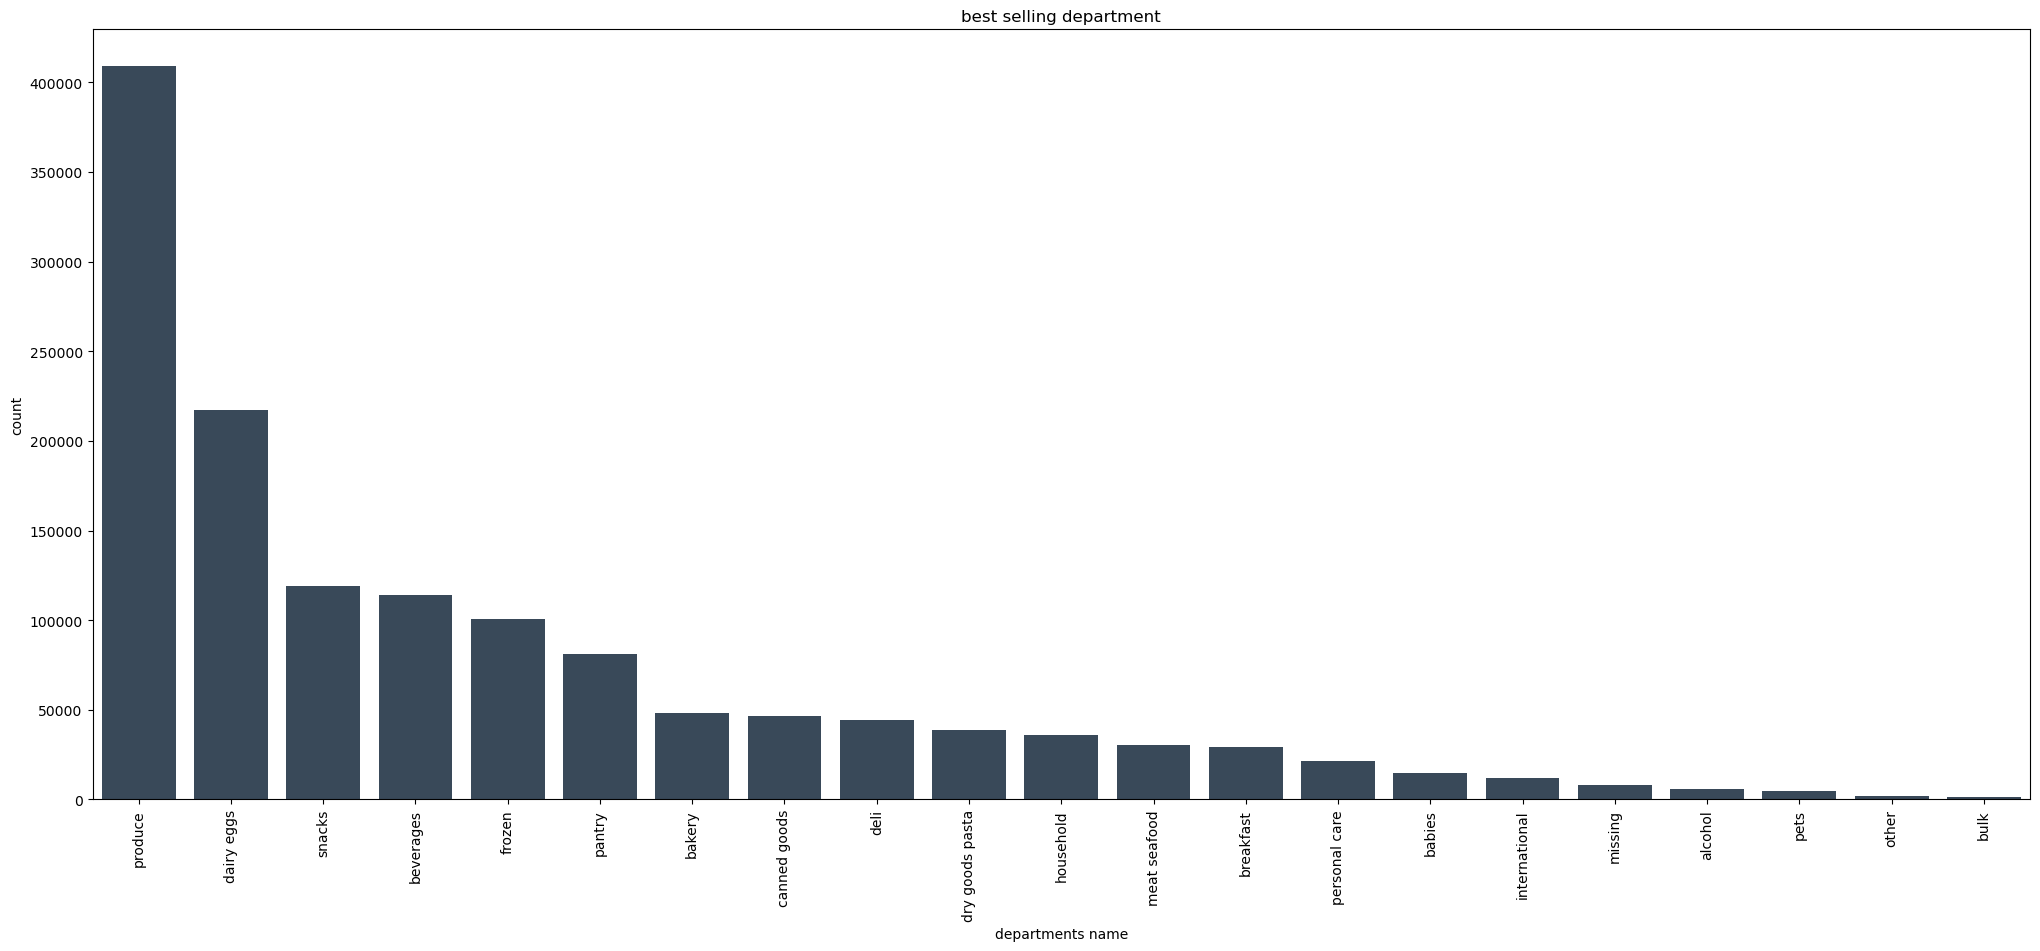

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
sn.barplot(data=departmentsCount.sort_values(by='count', ascending=False).head(30), x='department', y='count', ax=ax, orient='v', color="#34495e")
ax.set(xlabel="departments name", ylabel='count', title='best selling department')
plt.xticks(rotation=90)

In [31]:
orders.sort_values(by='order_id')

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [32]:
if 0 in orders['days_since_prior_order'].values:
    print(orders['days_since_prior_order'].value_counts())

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64


==============================

In [33]:
orders[orders['order_hour_of_day'] == 4]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
215,2483716,19,prior,8,4,4,7.0
1698,2224236,116,prior,6,1,4,10.0
1780,3242045,122,prior,22,4,4,5.0
2251,2003778,150,prior,15,0,4,10.0
2452,1643899,160,prior,7,1,4,12.0
...,...,...,...,...,...,...,...
3418218,1498717,206035,prior,16,5,4,28.0
3419290,2064960,206097,prior,4,6,4,30.0
3420059,2776704,206148,prior,25,3,4,3.0
3421013,9620,206207,prior,12,2,4,8.0


In [34]:
for i in orderProductsPrior[orderProductsPrior['order_id'] == 2776704]['product_id'].values:
    print(products[products['product_id'] == i].product_name.iloc[0])

Organic Russet Potato Bag
Organic Black Beans
2X Ultra High Efficiency Wave Auto Dishwasher Gel Free & Clear
Honeycrisp Apple
Red Plums
Banana
Organic Refried Black Beans
Organic Spring Mix Salad
Blueberry Muffin


In [35]:
departments['department'].values

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods',
       'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing'],
      dtype=object)

In [36]:
aisles['aisle'].values

array(['prepared soups salads', 'specialty cheeses',
       'energy granola bars', 'instant foods',
       'marinades meat preparation', 'other', 'packaged meat',
       'bakery desserts', 'pasta sauce', 'kitchen supplies',
       'cold flu allergy', 'fresh pasta', 'prepared meals',
       'tofu meat alternatives', 'packaged seafood', 'fresh herbs',
       'baking ingredients', 'bulk dried fruits vegetables',
       'oils vinegars', 'oral hygiene', 'packaged cheese', 'hair care',
       'popcorn jerky', 'fresh fruits', 'soap', 'coffee', 'beers coolers',
       'red wines', 'honeys syrups nectars', 'latino foods',
       'refrigerated', 'packaged produce', 'kosher foods',
       'frozen meat seafood', 'poultry counter', 'butter',
       'ice cream ice', 'frozen meals', 'seafood counter',
       'dog food care', 'cat food care', 'frozen vegan vegetarian',
       'buns rolls', 'eye ear care', 'candy chocolate', 'mint gum',
       'vitamins supplements', 'breakfast bars pastries',
       '